### Downloading Dataset 

In [1]:
import os 
from tqdm import tqdm
#from google.colab import drive
import shutil 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot  as plt
from pathlib import Path
import imagesize
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import pandas as pd
import zipfile 
import statistics 


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir dataset
!cp "gdrive/My Drive/DLL_project/dataset/Adaptiope.zip" dataset/
!ls dataset

Adaptiope.zip


In [ ]:
!unzip dataset/Adaptiope.zip

Streaming output truncated to the last 5000 lines.
  inflating: Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_01.png  
  inflating: Adaptiope/synthetic/purse/purse_4_08.png  
  inflating: Adaptiope/synthetic/purse/purse_4_09.png

In [ ]:
! rm -rf adaptiope_small

In [ ]:
! mkdir adaptiope_small

In [2]:
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

domains = ["product_images", "real_life"]




In [ ]:
with zipfile.ZipFile("data/Adaptiope.zip", 'r') as zip_f:
    namelist = zip_f.namelist() 
    images = [x for x in namelist if x.endswith(".jpg")]
    filter = [f"Adaptiope/{y}/{x}/" for y in domains for x in classes]
    cl_images = [x for x in images if x.startswith(tuple(filter))]
    zip_f.extractall(path = "data/", members= cl_images)

## EDA: Exploratory Data Analysis


In [3]:

metadata_img = {}

for domain in domains:
  #print(domain)
  subclass = os.listdir(f"data/Adaptiope/{domain}")
  for class_name in classes:
    imgs = [img.name for img in Path(f"data/Adaptiope/{domain}/{class_name}/").iterdir() if img.suffix == ".jpg"]
    for fl in imgs: 
      metadata_img[str(fl + domain)] = imagesize.get(f"data/Adaptiope/{domain}/{class_name}/"+fl)



In [4]:


# some statistics to check how many images we have and their dimensions (on average)
img_df = pd.DataFrame.from_dict([metadata_img]).T.reset_index().set_axis(['file_name', 'size'], axis='columns', inplace=False)
img_df[["width", "height"]] = pd.DataFrame(img_df["size"].tolist(), index=img_df.index)
avg_width = round(img_df["width"].sum() / len(img_df))
avg_height = round(img_df["height"].sum() / len(img_df))
sd_width = round(statistics.stdev(img_df["width"]), 2)
sd_height = round(statistics.stdev(img_df["height"]), 2)


print(f'Total images in Adaptiope dataset: {len(img_df)}')
print(f'Average height in Adaptiope dataset: {avg_height}')
print(f'SD height in Adaptiope dataset: {sd_height}')

print(f'Average width in Adaptiope dataset: {avg_width}')
print(f'SD width in Adaptiope dataset: {sd_width}')


Total images in Adaptiope dataset: 4000
Average height in Adaptiope dataset: 1122
SD height in Adaptiope dataset: 415.62
Average width in Adaptiope dataset: 1160
SD width in Adaptiope dataset: 415.42


In [5]:
thre = 1e-5
cond = np.logical_and(img_df['height'] - thre < img_df['width'], img_df['width'] < img_df['height'] + thre)
sq_df = img_df[cond]
print('Percentage square images:', len(sq_df.index)/len(img_df.index))

Percentage square images: 0.323


In [6]:
rect_df = img_df[~cond]
avg_size_diff = round(sum(abs(rect_df['width'] - rect_df['height'])) / len(rect_df.index), 2)
std_size_diff = round(statistics.stdev(abs(rect_df['width'] - rect_df['height'])), 2)
print(f'Size difference = {avg_size_diff} +/- {std_size_diff}')

Size difference = 421.57 +/- 258.17


In [7]:
print("Width:", "from", min(img_df["width"]), "to", max(img_df["width"]))
print("Height", "from", min(img_df["height"]), "to", max(img_df["height"]))

Width: from 120 to 2870
Height from 75 to 2560


## Data Transformation

In [17]:
def data_transformation_source(m = 256, n = 224, grayscale = True):
  """
  Data transformation for training data

  Args:
      m (int, optional): _description_. Defaults to 256.
      n (int, optional): _description_. Defaults to 224.

  Returns:
      _type_: _description_
  """
  
  transform_adaptiope_source = []
  transform_adaptiope_source.append(T.Resize((m)))                                          # resize each PIL image to m x m                  
  if grayscale:
      transform_adaptiope_source.append(T.Grayscale(num_output_channels=3))                        # to make RGB to grayscale
  transform_adaptiope_source.append(T.RandomCrop((n)))                                       # randomly crop a n x n patch
  transform_adaptiope_source.append(T.RandomHorizontalFlip(p=0.5))                                  
  transform_adaptiope_source.append(T.ToTensor())                                             
      
  return T.Compose(transform_adaptiope_source)  


def data_transformation_target(m = 256, n = 224, grayscale = True):
  """
  Data Transformation for test data

  Args:
      m (int, optional): _description_. Defaults to 256.
      n (int, optional): _description_. Defaults to 224.

  Returns:
      _type_: _description_
  """
  
  transform_adaptiope_target = []
  transform_adaptiope_target.append(T.Resize((m)))                                          # resize each PIL image to m x m                  
  if grayscale:
      transform_adaptiope_target.append(T.Grayscale(num_output_channels=3))                   # to make RGB to grayscale
  transform_adaptiope_target.append(T.CenterCrop(n))                                    # randomly crop a n x n patch
  transform_adaptiope_target.append(T.RandomHorizontalFlip(p=0.5))                                  
  transform_adaptiope_target.append(T.ToTensor())                                  
  
  return T.Compose(transform_adaptiope_target)    


In [20]:
source = "product_images"
source_ds = torchvision.datasets.ImageFolder(
    root=f"data/Adaptiope/{source}",
    transform = data_transformation_source(grayscale = False)
)
    

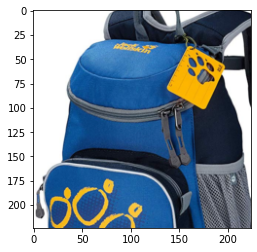

In [21]:

inputs, classes = next(iter(source_ds))
plt.imshow(inputs.permute(1, 2, 0))

In [22]:
# TODO: verificare valori pixel 

def normalization(ds):
    for img,_ in ds:
        r_mean, g_mean, b_mean = torch.mean(img, dim = [1,2])
        r_sd, g_sd, b_sd = torch.std(img, dim = [1,2])
        T.functional.normalize(
            tensor = img, 
            mean = [r_mean, g_mean, b_mean],
            std = [r_sd, g_sd, b_sd],
            inplace=True
        )
    return ds

normalization(source_ds)

    

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: data/Adaptiope/product_images
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

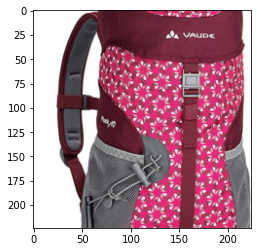

In [31]:
iterator_marks = iter(source_ds)
inputs, classes = next(iterator_marks)
inputs, classes = next(iterator_marks)
plt.imshow(inputs.permute(1, 2, 0))

In [ ]:
# TODO: implementare con sklearn lo split 

from sklearn.model_selection import StratifiedShuffleSplit

def get_data(batch_size, source = "product_images", target = "real_life"):     
                              
  # TODO: estrazione in data target e data source 
  # TODO: shuffle split (salvataggio cartella)
  # TODO: transform 
  # TODO: data loader 
  
  # load source and split train and test 
  source_data = torchvision.datasets.ImageFolder(root=f"data/Adaptiope/{source}", transform )

  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

  source_training_samples, source_test_samples = split.split(source_data, )
  
  source_training_data, source_test_data = torch.utils.data.random_split(source_data, 
                                                           [source_training_samples, source_test_samples])


  # load target and split in train and test 
  target_data = torchvision.datasets.ImageFolder(root=f"data/Adaptiope/{target}", transform=data_transformation())


  target_training_samples, target_test_samples = split_test_train(target_data)
  target_training_data, target_test_data = torch.utils.data.random_split(target_data, 
                                                           [target_training_samples, target_test_samples])

  # initialize dataloaders
  source_train_loader = torch.utils.data.DataLoader(source_training_data, batch_size, shuffle=True, drop_last=True)
  source_test_loader = torch.utils.data.DataLoader(source_test_data, batch_size, shuffle=False)
  
  target_train_loader = torch.utils.data.DataLoader(target_training_data, batch_size, shuffle=True, drop_last=True)
  target_test_loader = torch.utils.data.DataLoader(target_test_data, batch_size, shuffle=False)
  
  return source_train_loader, source_test_loader, target_train_loader, target_test_loader 




# Feature extraction 

- 

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

In [ ]:

for param in model.parameters():
    param.requires_grad = False

In [ ]:
features = model.fc.in_features

model.fc = nn.Linear(features, len(dataset.classes))
